In [54]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import shap
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
import numpy as np

In [55]:
data = pd.read_csv("wnba_clean.csv")

In [56]:
data.head()

,shot_type,made_shot,shot_value,coordinate_x,coordinate_y,home_score,away_score,qtr,quarter_seconds_remaining,game_seconds_remaining,shot_group,distance,shot_group_encoded,shot_type_encoded
0,Jump Shot,False,0,-13,9,0,0,1,571,2371,Jump Shot,15.811388,3,29
1,Turnaround Bank Jump Shot,False,0,0,0,0,0,1,551,2351,Jump Shot,0.000000,3,8
2,Cutting Layup Shot,True,2,-21,2,0,2,1,538,2338,Layup,21.095023,1,25
3,Driving Layup Shot,True,2,0,0,2,2,1,524,2324,Layup,0.000000,1,14
4,Jump Shot,True,3,0,21,2,5,1,512,2312,Jump Shot,21.000000,3,29


In [57]:
X = data.drop(columns=["made_shot", "shot_type", "shot_value", "shot_group"])
y = data['made_shot']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Random Forest

In [59]:
# Train the black-box model
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Generate predictions
y_black_box_train = model.predict(X_train)

### Post Hoc XAI

#### Feature-based 

In [60]:
X_train.columns

Index(['coordinate_x', 'coordinate_y', 'home_score', 'away_score', 'qtr',
       'quarter_seconds_remaining', 'game_seconds_remaining', 'distance',
       'shot_group_encoded', 'shot_type_encoded'],
      dtype='object')

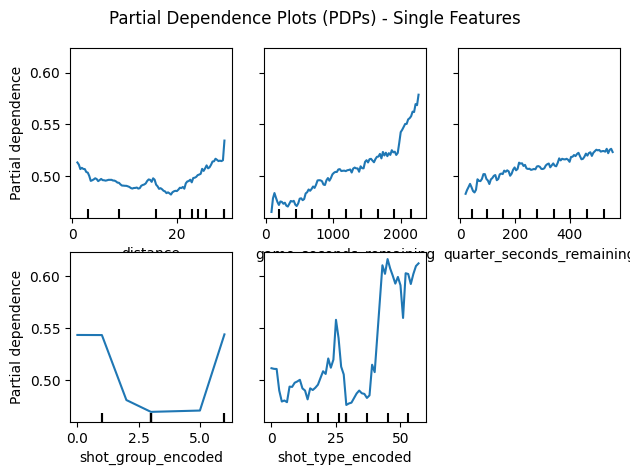

In [62]:
# Selected features for single-feature PDPs
selected_features = [7, 6, 5, 8, 9]

# Generate PDPs
PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    selected_features,
    feature_names=[
        "coordinate_x", 
        "coordinate_y", 
        "home_score", 
        "away_score", 
        "qtr", 
        "quarter_seconds_remaining", 
        "game_seconds_remaining", 
        "distance", 
        "shot_group_encoded", 
        "shot_type_encoded"
    ],
    grid_resolution=100,
)

# Display the plot
plt.suptitle("Partial Dependence Plots (PDPs) - Single Features")
plt.tight_layout()
plt.show()

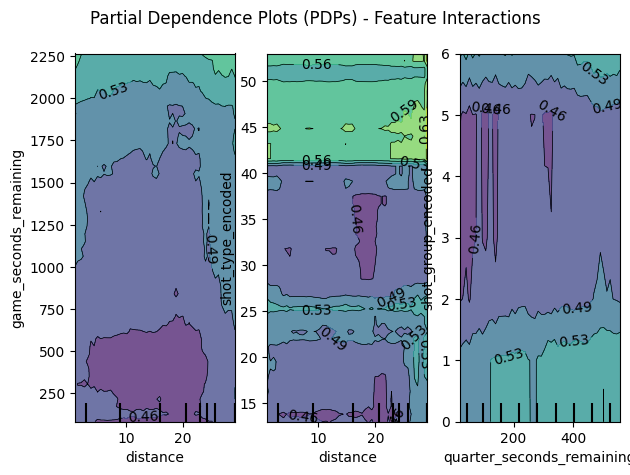

In [63]:
# Selected feature pairs for two-feature PDPs
interaction_features = [(7, 6), (7, 9), (5, 8)]  # distance vs game_seconds_remaining, etc.

# Generate 2D PDPs
PartialDependenceDisplay.from_estimator(
    model,
    X_train,
    interaction_features,
    feature_names=[
        "coordinate_x", 
        "coordinate_y", 
        "home_score", 
        "away_score", 
        "qtr", 
        "quarter_seconds_remaining", 
        "game_seconds_remaining", 
        "distance", 
        "shot_group_encoded", 
        "shot_type_encoded"
    ],
    grid_resolution=50,
)

# Display the plot
plt.suptitle("Partial Dependence Plots (PDPs) - Feature Interactions")
plt.tight_layout()
plt.show()


100%|===================| 58091/58094 [109:41<00:00]        

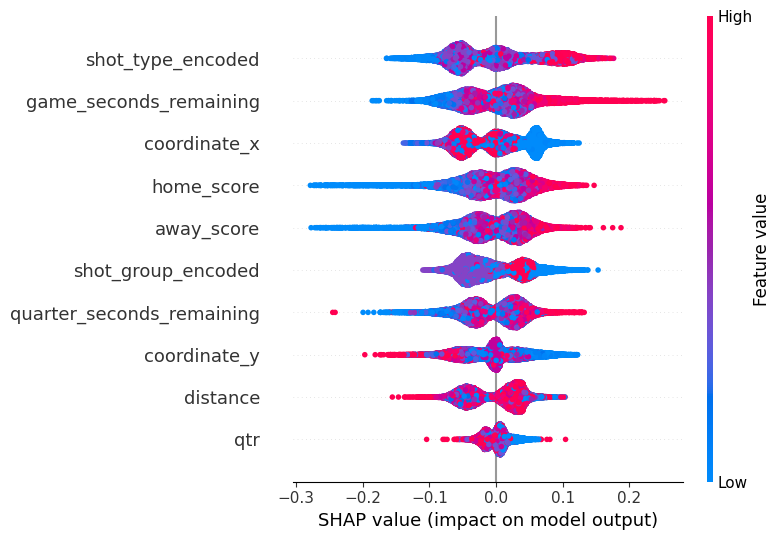

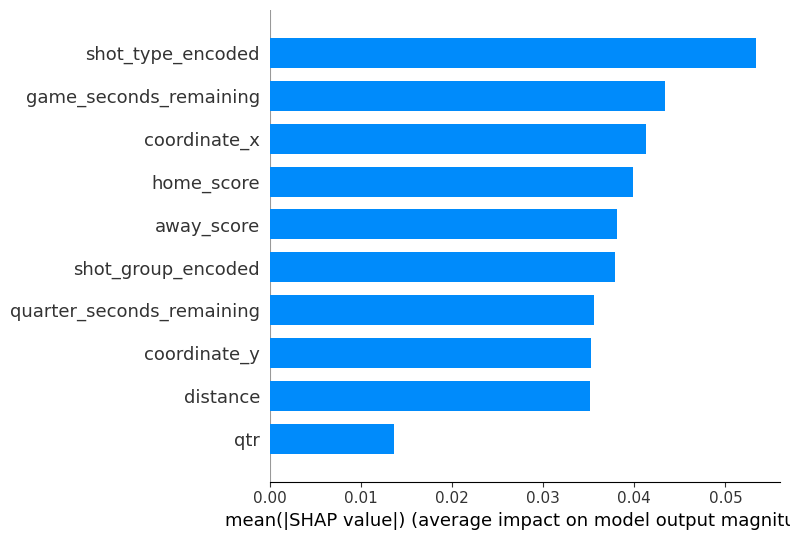

In [64]:
explainer = shap.Explainer(model, X_train)  # Initialize SHAP Explainer
shap_values = explainer(X_train)           

# Step 7: Visualize SHAP Values for Positive Class
shap_values_class1 = shap_values[..., 1] 

# SHAP Summary Plot
shap.summary_plot(shap_values_class1, X_train)

# SHAP Bar Plot
shap.summary_plot(shap_values_class1, X_train, plot_type="bar")


In [30]:
# Subset the training data (e.g., only the first 100 rows)
subset_X_train = X_train.iloc[:100]

In [33]:
feature_index = 7
feature_name = 'distance'

# Obtain ICE data
ice_results = partial_dependence(
    model, subset_X_train, [feature_index], grid_resolution=50, kind="individual"
)

In [34]:
feature_values = ice_results["grid_values"][0]  # Grid of feature values
ice_curves = ice_results["individual"][0]  # Individual curves (ICE)

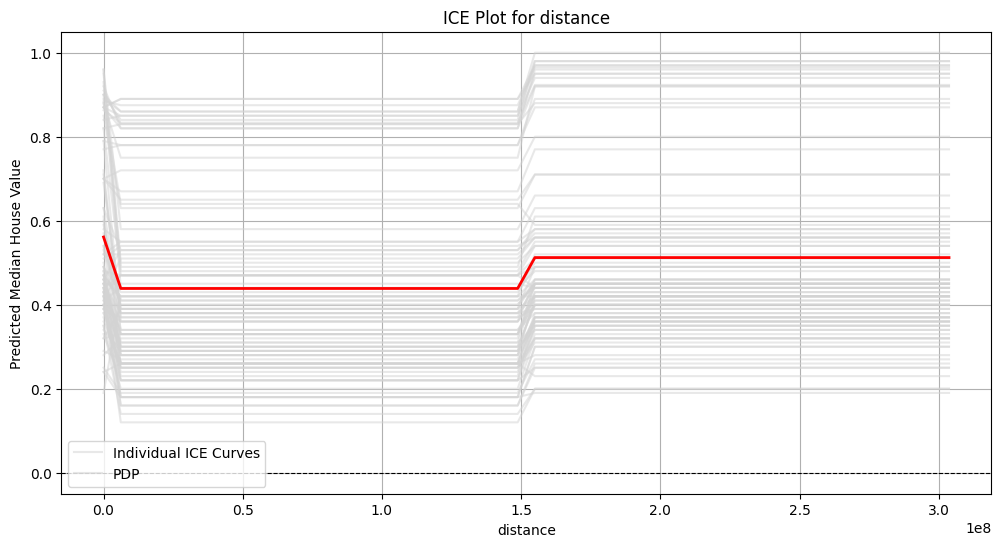

In [37]:
# Plot ICE Curves
plt.figure(figsize=(12, 6))

# Plot individual ICE curves
for ice_curve in ice_curves:
    plt.plot(feature_values, ice_curve, color="lightgray", alpha=0.5)
    
# Highlight the average curve (PDP)
average_curve = np.mean(ice_curves, axis=0)
plt.plot(feature_values, average_curve, color="red", label="PDP", linewidth=2)

# Add labels and title
plt.title(f"ICE Plot for {feature_name}")
plt.xlabel(feature_name)
plt.ylabel("Predicted Median House Value")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.legend(["Individual ICE Curves", "PDP"])
plt.grid()
plt.show()

#### Simplification-based: Surrogate Model

In [39]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss

In [45]:
# Generate predictions
rf_preds = model.predict(X_train)  

In [51]:
# Train the surrogate model (Decision Tree)
surrogate_model = DecisionTreeClassifier(max_depth=3, random_state=42)
surrogate_model.fit(X_train, rf_preds)  # Train on RF predictions

# Evaluate the surrogate model
# Agreement Rate
surrogate_preds = surrogate_model.predict(X_train)
agreement_rate = accuracy_score(rf_preds, surrogate_preds)

# Print Results
print(f"Agreement Rate: {agreement_rate:.4f}")

Agreement Rate: 0.6675


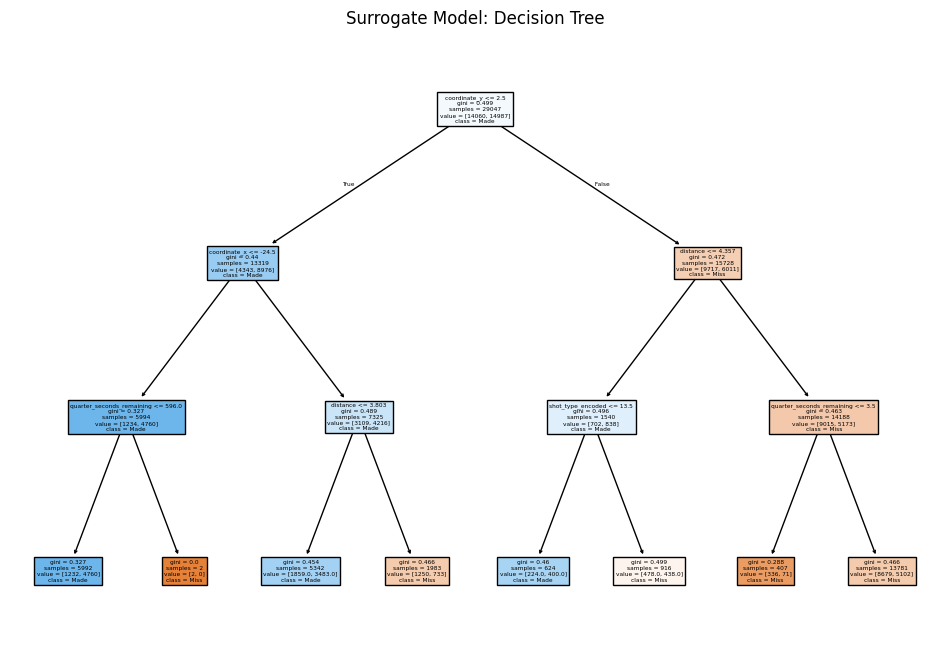

In [52]:
# Visualize the surrogate model
from sklearn.tree import plot_tree
plt.figure(figsize=(12, 8))
plot_tree(surrogate_model, feature_names=X.columns, filled=True, class_names=['Miss', 'Made'])
plt.title("Surrogate Model: Decision Tree")
plt.show()

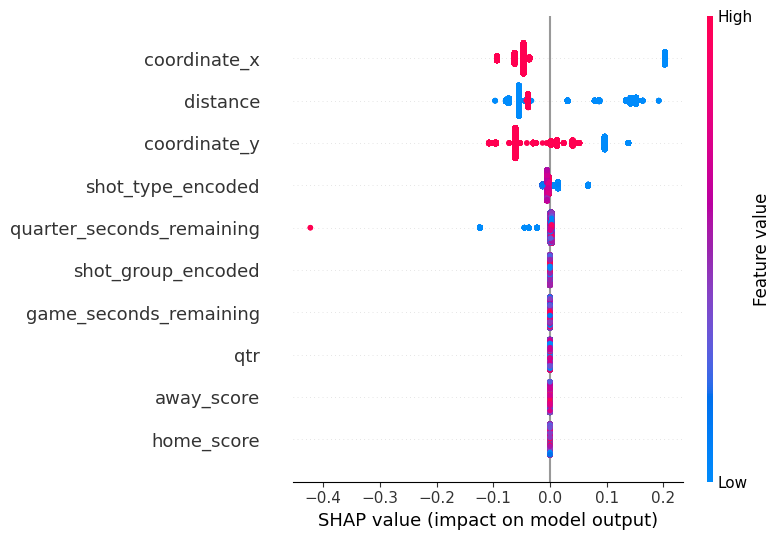

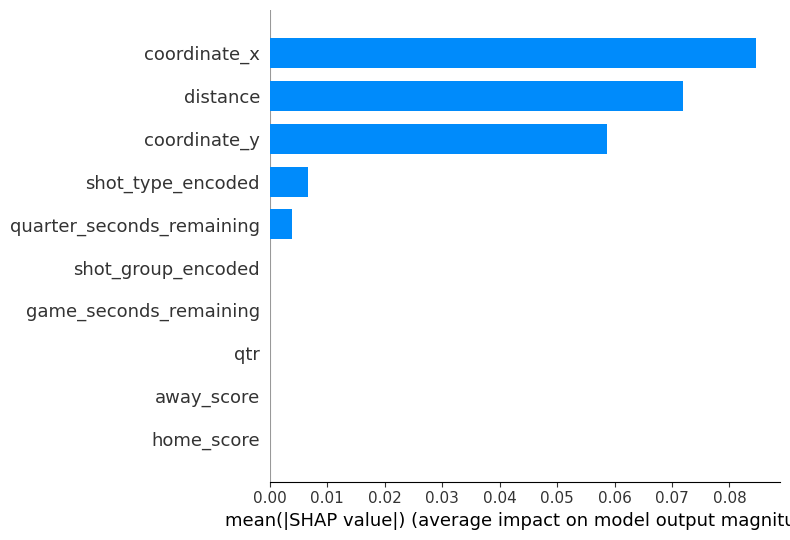

In [53]:
#Explain Predictions with SHAP for surrogate model
explainer = shap.Explainer(surrogate_model, X_train)  # Initialize SHAP Explainer
shap_values = explainer(X_train)              # Compute SHAP values

# Visualize SHAP Values for Positive Class (class 1)
shap_values_class1 = shap_values[..., 1]  # Select SHAP values for class 1 (if binary classification)

# SHAP Summary Plot
shap.summary_plot(shap_values_class1, X_train)

# SHAP Bar Plot
shap.summary_plot(shap_values_class1, X_train, plot_type="bar")
